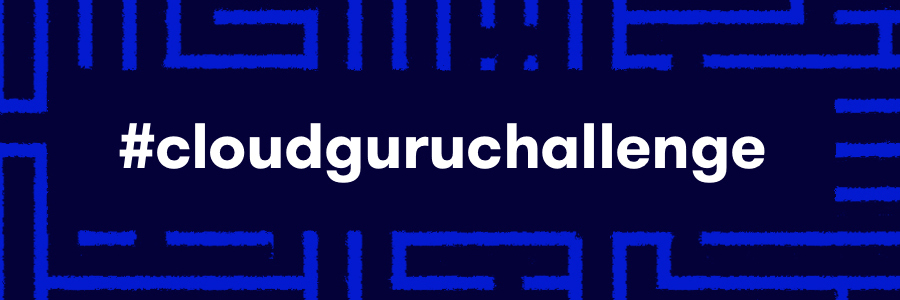

# Introduction

This Jupyter Notebook provides a detailed overview of the code tasked with building and deploying a Netflix style recommendation engine using machine learning on AWS.

# Scenario
We will be using public datasets provided from IMDb to suggest a movie based on a select individual's genre of choice. The datasets will eventually be modified and condensed to make a single, easy to process file. We will be recommending movies within the clusters that are only in English.
#### Genres (in no particular order)
* Drama
* Romance
* Action
* Crime
* Adventure
* Biography
* Fantasy
* Mystery
* Comedy
* Family
* War
* History
* Sci-Fi
* Thriller
* Horror
* Musical
* Animation
* Western

Python libraries such as Pandas & NumPy will be used alongside scikit-learn.


# Cleaning & Preparing the Data
In order to save execution time I have locally modified and condensed the raw IMDb datasets we will be using into (1) file. The datasets were downloaded on 10/31/20. Code hosted locally on a Jupyter Notebook within VSCode.

*Disclaimer: this code block will not run properly within this Jupyter Notebook.

In [ ]:
import pandas as pd 
import numpy as np

basics = pd.read_table('basics.tsv')
origin = pd.read_table('akas.tsv')
ratings = pd.read_table('ratings.tsv')

#dropping and renaming columns in basics.tsv
basics.drop(basics.columns[[3,4,6,7]], axis=1, inplace=True)
basics.columns = ['tconst','type','title','year','genre']

#removing all non-movies from index
cond1 = basics['type'].isin(['movie','tvMovie'])

#setting new 'basics' variable
basics2 = basics[cond1]

#dropping and renaming columns in akas.tsv
origin.drop(origin.columns[[1,2,5,6,7]], axis = 1, inplace = True)
origin.columns = ['tconst','region','language']

#removing non-english movies from index
cond2 = origin['region'].isin(['US','GB'])
cond3 = origin['language'] == 'en'

#setting new 'origin' variable
origin2 = origin[cond2 | cond3]

#renaming columns in ratings.tsv
ratings.columns = ['tconst','rating','votecount']

#converting rating score strings to integers
ratings.rating = pd.to_numeric(ratings.rating, errors='coerce').astype(np.int64)
ratings.votecount = pd.to_numeric(ratings.votecount, errors='coerce').astype(np.int64)

#setting new 'ratings' variable and filtering outliers
ratings2 = ratings[(ratings['rating'] >= 5) & (ratings['votecount'] >= 50)]

#finalizing movie recommendation list 
rcmd = basics2.merge(origin2,on='tconst').merge(ratings2,on='tconst')
rcmd.drop_duplicates(subset = 'tconst', keep ="first", inplace = True) 
rcmd.to_csv('recommend.csv', header = True, index = False)

# 1) Import Libraries


In [1]:
# Most of these includes are pretty standard 
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

# If you want to be able to reproduce results, we can uncomment the next line:
# np.random.seed(123)

# Libraries like to warn us of things, but we'll 
# turn this off for now.
pd.options.mode.chained_assignment = None
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# These two includes help us render a graph
from subprocess import call
from IPython.display import Image

# 2) Load the Data
I have already condensed the raw datasets into one file containing the information needed to meet the necessary requirements of this project.

In [2]:
rcmd = pd.read_csv('recommend.csv')

In [3]:
rcmd.head(10)

tconst   type                                              title  year  \
0  tt0000009  movie                                         Miss Jerry  1894   
1  tt0001258  movie                              The White Slave Trade  1910   
2  tt0001892  movie                                     Den sorte drøm  1911   
3  tt0001964  movie                                      The Traitress  1911   
4  tt0002101  movie                                          Cleopatra  1912   
5  tt0002130  movie                                    Dante's Inferno  1911   
6  tt0002186  movie                                  The Flying Circus  1912   
7  tt0002199  movie  From the Manger to the Cross; or, Jesus of Naz...  1912   
8  tt0002281  movie                                       The Invaders  1912   
9  tt0002423  movie                                            Passion  1919   

                     genre region language  rating  votecount  
0                  Romance     US       \N       5        155  
1                    Drama    XWW       en       5         86  
2                    Drama     US       \N       5        189  
3                    Drama     US       \N       6         59  
4            Drama,History     US       \N       5        451  
5  Adventure,Drama,Fantasy     US       \N       7       2281  
6                    Drama     US       \N       6         90  
7          Biography,Drama     US       \N       5        487  
8                  Western     US       \N       6        259  
9  Biography,Drama,Romance     GB       \N       6        758

# 3) Training

For now we will get rid of the columns not relevant to building the recommendation engine (and string columns).

In [4]:
rcmd.drop(['type','title','year','region','language','rating','votecount'], axis=1, inplace=True)

Make the "tconst" or Movie ID values able to pass into the model.

In [5]:
rcmd.tconst = rcmd.tconst.str.strip('tt')

Next we will set conditions for each cluster and manually perform the one-hot encoding get_dummies() would do.

In [6]:
rcmd['c1'] = rcmd['genre'].str.contains('Family', na=False)
rcmd['c2'] = rcmd['genre'].str.contains('Animation', na=False)
rcmd['c3'] = rcmd['genre'].str.contains('Comedy', na=False)
rcmd['c4'] = rcmd['genre'].str.contains('War', na=False)
rcmd['c5'] = rcmd['genre'].str.contains('Western', na=False)
rcmd['c6'] = rcmd['genre'].str.contains('History', na=False)
rcmd['c7'] = rcmd['genre'].str.contains('Thriller', na=False)
rcmd['c8'] = rcmd['genre'].str.contains('Horror', na=False)
rcmd['c9'] = rcmd['genre'].str.contains('Mystery', na=False)
rcmd['c10'] = rcmd['genre'].str.contains('Action', na=False)
rcmd['c11'] = rcmd['genre'].str.contains('Crime', na=False)
rcmd['c12'] = rcmd['genre'].str.contains('Adventure', na=False)
rcmd['c13'] = rcmd['genre'].str.contains('Fantasy', na=False)
rcmd['c14'] = rcmd['genre'].str.contains('Sci-Fi', na=False)
rcmd['c15'] = rcmd['genre'].str.contains('Drama', na=False)
rcmd['c16'] = rcmd['genre'].str.contains('Romance', na=False)
rcmd['c17'] = rcmd['genre'].str.contains('Biography', na=False)
rcmd['c18'] = rcmd['genre'].str.contains('Musical', na=False)

In [7]:
rcmd.head(10)

tconst                    genre     c1     c2     c3     c4     c5     c6  \
0  0000009                  Romance  False  False  False  False  False  False   
1  0001258                    Drama  False  False  False  False  False  False   
2  0001892                    Drama  False  False  False  False  False  False   
3  0001964                    Drama  False  False  False  False  False  False   
4  0002101            Drama,History  False  False  False  False  False   True   
5  0002130  Adventure,Drama,Fantasy  False  False  False  False  False  False   
6  0002186                    Drama  False  False  False  False  False  False   
7  0002199          Biography,Drama  False  False  False  False  False  False   
8  0002281                  Western  False  False  False  False   True  False   
9  0002423  Biography,Drama,Romance  False  False  False  False  False  False   

      c7     c8     c9    c10    c11    c12    c13    c14    c15    c16  \
0  False  False  False  False  False  False  False  False  False   True   
1  False  False  False  False  False  False  False  False   True  False   
2  False  False  False  False  False  False  False  False   True  False   
3  False  False  False  False  False  False  False  False   True  False   
4  False  False  False  False  False  False  False  False   True  False   
5  False  False  False  False  False   True   True  False   True  False   
6  False  False  False  False  False  False  False  False   True  False   
7  False  False  False  False  False  False  False  False   True  False   
8  False  False  False  False  False  False  False  False  False  False   
9  False  False  False  False  False  False  False  False   True   True   

     c17    c18  
0  False  False  
1  False  False  
2  False  False  
3  False  False  
4  False  False  
5  False  False  
6  False  False  
7   True  False  
8  False  False  
9   True  False

In [8]:
X_train, X_test, y_train, y_test = train_test_split(rcmd.drop('genre', 1), rcmd['c1'], test_size = .2, random_state=10)

In [9]:
model = RandomForestClassifier(max_depth=5, n_estimators=20)

In [10]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# 4) Testing

First we will choose which tree (estimator) to view.

In [11]:
estimator = model.estimators_[1]
feature_names = [i for i in X_train.columns]

Now we will use Seaborn to visualize the RF.

In [13]:
export_graphviz(estimator, out_file='tree.dot', feature_names = feature_names, filled = True)
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
Image(filename = 'tree.png')

Our model works, but does not quite classify and recommend the way we would like it to. That's unsupervised learning for you!

But we will still pass the the testing data thru the model for best practice.

In [14]:
y_predict = model.predict(X_test)
y_pred_quant = model.predict_proba(X_test)[:, 1]
y_pred_bin = model.predict(X_test)